# PACO Benchmark en Google Colab

Este notebook ejecuta el benchmark de PACO con datos reales en **Google Colab**.

## 📋 Requisitos Previos

1. **Sube los archivos .fits a Google Drive:**
   - Crea carpeta: `PACO_Challenge_Data`
   - Sube: `sphere_irdis_cube_1.fits`, `sphere_irdis_pa_1.fits`, `sphere_irdis_psf_1.fits`, `sphere_irdis_pxscale_1.fits`

2. **Sube el código PACO a Google Drive:**
   - Comprime `PACO-master` en ZIP
   - Súbelo a Drive y descomprímelo
   - O clona desde GitHub si tienes repositorio

## ⚙️ Configuración

Ajusta las rutas en la celda de configuración según tu estructura en Drive.


In [ ]:
# ============================================================================
# INSTALAR DEPENDENCIAS
# ============================================================================
!pip install -q astropy numpy scipy matplotlib joblib pandas

print("✅ Dependencias instaladas")


In [ ]:
# ============================================================================
# MONTAR GOOGLE DRIVE
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive montado")


In [ ]:
# ============================================================================
# CONFIGURAR RUTAS
# ============================================================================
import sys
from pathlib import Path
import numpy as np

# ⚠️ AJUSTA ESTAS RUTAS SEGÚN TU ESTRUCTURA EN GOOGLE DRIVE
PACO_DIR = Path("/content/drive/MyDrive/PACO-master")  # Ruta al código PACO
DATA_DIR = Path("/content/drive/MyDrive/PACO_Challenge_Data")  # Ruta a archivos .fits
OUTPUT_DIR = Path("/content/drive/MyDrive/PACO_Results")  # Donde guardar resultados

# Verificar que existan
if not PACO_DIR.exists():
    print(f"⚠️ ADVERTENCIA: {PACO_DIR} no existe")
    print("   Sube el código de PACO a Google Drive")
    print("   O ajusta la ruta PACO_DIR en esta celda")
else:
    sys.path.insert(0, str(PACO_DIR))
    print(f"✅ PACO encontrado en: {PACO_DIR}")

if not DATA_DIR.exists():
    print(f"⚠️ ADVERTENCIA: {DATA_DIR} no existe")
    print("   Crea esta carpeta en Drive y sube los archivos .fits")
    print("   O ajusta la ruta DATA_DIR en esta celda")
else:
    print(f"✅ Datos encontrados en: {DATA_DIR}")
    # Listar archivos disponibles
    fits_files = list(DATA_DIR.glob("*.fits"))
    print(f"   Archivos .fits encontrados: {len(fits_files)}")
    if fits_files:
        print("   Primeros archivos:")
        for f in fits_files[:5]:
            print(f"     - {f.name}")

OUTPUT_DIR.mkdir(exist_ok=True)
print(f"✅ Resultados se guardarán en: {OUTPUT_DIR}")


In [ ]:
# ============================================================================
# IMPORTAR MÓDULOS DE PACO
# ============================================================================
try:
    from paco_real_data_benchmark import (
        load_challenge_dataset,
        prepare_dataset_for_paco,
        benchmark_real_dataset,
        benchmark_all_datasets
    )
    from paco_performance_benchmark import (
        BENCHMARK_CONFIG,
        analyze_amdahl,
        plot_benchmark_results,
        save_results,
        analyze_scalability
    )
    print("✅ Módulos de PACO importados correctamente")
except ImportError as e:
    print(f"❌ Error importando módulos: {e}")
    print("   Verifica que:")
    print("   1. El código de PACO esté en la ruta correcta")
    print("   2. La ruta PACO_DIR esté bien configurada")
    print("   3. Todos los archivos .py estén presentes")


## ⚙️ Configuración del Benchmark

Configura los parámetros del benchmark. Puedes ajustar:
- `cpu_counts`: Números de CPUs a probar (Colab tiene múltiples CPUs)
- `n_trials`: Número de ejecuciones por configuración
- `crop_size`: Tamaño para recortar imágenes grandes (reduce memoria)


In [ ]:
# ============================================================================
# CONFIGURACIÓN DEL BENCHMARK
# ============================================================================
config = BENCHMARK_CONFIG.copy()

# Colab tiene múltiples CPUs disponibles
config['cpu_counts'] = [4, 8]  # Solo probar con 4 y 8 CPUs (serial se ejecuta siempre)
n_trials = 1  # Número de ejecuciones por configuración (1 para pruebas rápidas)

# IMPORTANTE: Recortar imágenes grandes para evitar errores de memoria
# El dataset SPHERE-IRDIS tiene 160x160, lo cual requiere ~301 GiB de RAM sin recortar
# Recortamos a 100x100 para hacerlo manejable (~30 GiB)
crop_size = (100, 100)  # Recortar a 100x100 píxeles centrado

# Forzar que solo se ejecute serial y loky (no multiprocessing)
# Esto es importante en Colab/notebooks
import os
os.environ['SKIP_MULTIPROCESSING'] = '1'

print("=" * 70)
print("CONFIGURACIÓN DEL BENCHMARK")
print("=" * 70)
print(f"  CPU counts: {config['cpu_counts']} (solo para loky, serial siempre se ejecuta)")
print(f"  N trials: {n_trials}")
print(f"  Crop size: {crop_size} (IMPORTANTE: reduce uso de memoria)")
print(f"  Métodos: Serial (siempre) y Loky (con 4 y 8 CPUs)")
print("=" * 70)


## 📊 Cargar y Explorar Dataset

Primero, carguemos un dataset para verificar que todo esté correcto.


In [ ]:
# Cargar un dataset de ejemplo (SPHERE-IRDIS dataset 1)
dataset = load_challenge_dataset(DATA_DIR, instrument='sphere_irdis', dataset_id=1)

if dataset:
    print(f"\n✅ Dataset cargado:")
    print(f"  Instrumento: {dataset['instrument']}")
    print(f"  Dataset ID: {dataset['dataset_id']}")
    print(f"  Cube shape: {dataset['cube'].shape}")
    print(f"  Angles: {len(dataset['angles'])} frames")
    print(f"  PSF shape: {dataset['psf'].shape}")
    print(f"  Pixel scale: {dataset['pxscale']} arcsec/pixel")
    
    # Preparar para PACO
    paco_data = prepare_dataset_for_paco(dataset, crop_size=crop_size)
    print(f"\n📦 Datos preparados para PACO:")
    print(f"  Image size: {paco_data['image_size']}")
    print(f"  PSF radius: {paco_data['psf_rad']}")
    print(f"  Patch size: {paco_data['patch_size']}")
else:
    print("❌ No se pudo cargar el dataset")
    print(f"   Verifica que los archivos .fits estén en: {DATA_DIR}")


## 🚀 Ejecutar Benchmark

Ejecutemos el benchmark completo. Esto puede tomar varios minutos.


In [ ]:
# Ejecutar benchmark en SPHERE-IRDIS dataset 1
results = benchmark_real_dataset(
    data_dir=DATA_DIR,
    instrument='sphere_irdis',
    dataset_id=1,
    config=config,
    crop_size=crop_size,
    n_trials=n_trials
)

if results:
    print("\n✅ Benchmark completado exitosamente")
else:
    print("\n❌ Error ejecutando benchmark")


## 📈 Analizar Resultados

Analicemos los resultados usando la ley de Amdahl.


In [ ]:
if 'results' in locals() and results:
    # Análisis de Amdahl
    analysis = analyze_amdahl(results)
    
    print("\n" + "="*70)
    print("ANÁLISIS DE RESULTADOS: FastPACO vs FullPACO")
    print("="*70)
    
    # FastPACO
    print("\n" + "="*70)
    print("FASTPACO (Algorithm 2 - Precomputación de Estadísticas)")
    print("="*70)
    if analysis.get('serial'):
        print(f"\n⏱️  Serial (baseline): {analysis['serial']['mean_time']:.2f} ± {analysis['serial']['std_time']:.2f} segundos")
    
    if analysis.get('loky'):
        print(f"\n🚀 LOKY:")
        for n_cpu in sorted(analysis['loky'].keys()):
            if analysis['loky'][n_cpu]:
                data = analysis['loky'][n_cpu]
                print(f"  {n_cpu} CPUs: {data['mean_time']:.2f} ± {data['std_time']:.2f} s | "
                      f"Speedup: {data['speedup']:.2f}x | Eficiencia: {data['efficiency']:.1%}")
    
    # FullPACO
    if analysis.get('fullpaco_serial') and analysis['fullpaco_serial'].get('mean_time'):
        print("\n" + "="*70)
        print("FULLPACO (Algorithm 1 - Precisión Subpixel Completa)")
        print("="*70)
        fp_serial = analysis['fullpaco_serial']
        print(f"\n⏱️  Serial (baseline): {fp_serial['mean_time']:.2f} ± {fp_serial['std_time']:.2f} segundos")
        
        if analysis.get('fullpaco_loky'):
            print(f"\n🚀 LOKY:")
            for n_cpu in sorted(analysis['fullpaco_loky'].keys()):
                if analysis['fullpaco_loky'][n_cpu]:
                    data = analysis['fullpaco_loky'][n_cpu]
                    print(f"  {n_cpu} CPUs: {data['mean_time']:.2f} ± {data['std_time']:.2f} s | "
                          f"Speedup: {data['speedup']:.2f}x | Eficiencia: {data['efficiency']:.1%}")
    
    # Análisis de Amdahl
    if analysis.get('speedup_analysis'):
        p_mean = analysis['speedup_analysis'].get('p_mean', 0)
        max_speedup = analysis['speedup_analysis'].get('max_theoretical_speedup', 0)
        print("\n" + "="*70)
        print("ANÁLISIS DE AMDahl")
        print("="*70)
        print(f"\n📊 Fracción paralelizable (p): {p_mean:.3f}")
        print(f"📈 Speedup máximo teórico: {max_speedup:.2f}x")
    
    # Comparación directa
    if (analysis.get('serial') and analysis.get('fullpaco_serial') and 
        analysis['fullpaco_serial'].get('mean_time')):
        print("\n" + "="*70)
        print("COMPARACIÓN DIRECTA")
        print("="*70)
        fastpaco_time = analysis['serial']['mean_time']
        fullpaco_time = analysis['fullpaco_serial']['mean_time']
        ratio = fullpaco_time / fastpaco_time
        print(f"\n⚡ FastPACO Serial: {fastpaco_time:.2f} s")
        print(f"🎯 FullPACO Serial: {fullpaco_time:.2f} s")
        print(f"📊 FullPACO es {ratio:.2f}x más lento que FastPACO (trade-off por precisión)")
else:
    print("⚠️  No hay resultados para analizar. Ejecuta primero el benchmark.")


## 📊 Visualizar Resultados

Generemos gráficos de los resultados.


In [ ]:
if 'results' in locals() and results and 'analysis' in locals():
    # Generar gráficos
    plot_path = OUTPUT_DIR / "benchmark_plots.png"
    try:
        plot_benchmark_results(results, analysis, save_path=str(plot_path))
        print(f"\n✅ Gráficos guardados en: {plot_path}")
    except Exception as e:
        print(f"\n❌ ERROR generando gráficos: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️  No hay resultados para visualizar. Ejecuta primero el benchmark y análisis.")


## 💾 Guardar Resultados

Guardemos los resultados en archivos JSON y CSV para análisis posterior.


In [ ]:
if 'results' in locals() and results and 'analysis' in locals():
    # Guardar resultados
    json_path, csv_path = save_results(results, analysis, config, OUTPUT_DIR)
    
    print(f"\n✅ Resultados guardados:")
    print(f"  📄 JSON: {json_path}")
    print(f"  📊 CSV: {csv_path}")
    print(f"\n📁 Todos los resultados están en: {OUTPUT_DIR}")
    print("   Puedes descargarlos desde Google Drive cuando los necesites")
else:
    print("⚠️  No hay resultados para guardar. Ejecuta primero el benchmark y análisis.")


## 📈 Análisis de Escalabilidad

Comparemos cómo escala el algoritmo con diferentes números de CPUs.


In [ ]:
if 'results' in locals() and results and 'analysis' in locals():
    # Análisis de escalabilidad
    analyze_scalability(results, analysis)
else:
    print("⚠️  No hay resultados para analizar. Ejecuta primero el benchmark y análisis.")


# PACO Performance Benchmark con Datos Reales del EIDC Phase 1

Este notebook ejecuta el benchmark de rendimiento de PACO usando los datos reales del **Exoplanet Imaging Data Challenge Phase 1**.

## Referencias
- [EIDC Phase 1 Datasets](https://exoplanet-imaging-challenge.github.io/datasets1/)
- [EIDC Phase 1 Submission](https://exoplanet-imaging-challenge.github.io/submission1/)
- [EIDC Starting Kit](https://exoplanet-imaging-challenge.github.io/startingkit/)

## Datasets disponibles

Los datasets del challenge incluyen:
- **VLT/SPHERE-IRDIS**: 3 datasets
- **Keck/NIRC2**: 3 datasets
- **LBT/LMIRCam**: 3 datasets

Cada dataset contiene:
- `instrument_cube_id.fits`: Cubo de imágenes (3D array)
- `instrument_pa_id.fits`: Ángulos de paralaje (1D array)
- `instrument_psf_id.fits`: PSF template (2D array)
- `instrument_pxscale_id.fits`: Pixel scale (float)


In [5]:
# Importar módulos necesarios
import sys
from pathlib import Path
import numpy as np

# Agregar el directorio actual al path
sys.path.insert(0, str(Path.cwd()))

# Importar funciones del benchmark
from paco_real_data_benchmark import (
    load_challenge_dataset,
    prepare_dataset_for_paco,
    benchmark_real_dataset,
    benchmark_all_datasets
)
from paco_performance_benchmark import (
    BENCHMARK_CONFIG,
    analyze_amdahl,
    plot_benchmark_results,
    save_results,
    analyze_scalability
)

print("Módulos importados correctamente")


Módulos importados correctamente


## Configuración del Benchmark

Configura los parámetros del benchmark. Puedes ajustar:
- `cpu_counts`: Números de CPUs a probar
- `n_trials`: Número de ejecuciones por configuración
- `crop_size`: Tamaño para recortar imágenes grandes (opcional, para acelerar)


In [ ]:
# Configuración del benchmark
config = BENCHMARK_CONFIG.copy()

# Ajustar según tu sistema - Solo probar con 4 y 8 CPUs (serial se ejecuta siempre)
config['cpu_counts'] = [4, 8]  # Solo probar con 4 y 8 CPUs
n_trials = 1  # Número de ejecuciones por configuración (1 para pruebas rápidas)

# IMPORTANTE: Recortar imágenes grandes para evitar errores de memoria
# El dataset SPHERE-IRDIS tiene 160x160, lo cual requiere ~301 GiB de RAM
# Recortamos a 100x100 para hacerlo manejable (~30 GiB)
crop_size = (100, 100)  # Recortar a 100x100 píxeles centrado

# Forzar que solo se ejecute serial y loky (no multiprocessing)
# Esto se hace automáticamente en notebooks, pero lo hacemos explícito
import os
os.environ['SKIP_MULTIPROCESSING'] = '1'

print("Configuración:")
print(f"  CPU counts: {config['cpu_counts']} (solo para loky, serial siempre se ejecuta)")
print(f"  N trials: {n_trials}")
print(f"  Crop size: {crop_size} (IMPORTANTE: reduce uso de memoria)")
print(f"  Métodos: Serial (siempre) y Loky (con 4 y 8 CPUs)")


Configuración:
  CPU counts: [4, 8] (solo para loky, serial siempre se ejecuta)
  N trials: 3
  Crop size: None
  Métodos: Serial (siempre) y Loky (con 4 y 8 CPUs)


## Cargar y Explorar un Dataset

Primero, carguemos un dataset para explorar su estructura.


In [7]:
# Directorio con los datos del challenge
data_dir = Path("../subchallenge1")

# Cargar un dataset de ejemplo (SPHERE-IRDIS dataset 1)
dataset = load_challenge_dataset(data_dir, instrument='sphere_irdis', dataset_id=1)

if dataset:
    print(f"\nDataset cargado:")
    print(f"  Instrumento: {dataset['instrument']}")
    print(f"  Dataset ID: {dataset['dataset_id']}")
    print(f"  Cube shape: {dataset['cube'].shape}")
    print(f"  Angles: {len(dataset['angles'])} frames")
    print(f"  PSF shape: {dataset['psf'].shape}")
    print(f"  Pixel scale: {dataset['pxscale']} arcsec/pixel")
    
    # Preparar para PACO
    paco_data = prepare_dataset_for_paco(dataset, crop_size=crop_size)
    print(f"\nDatos preparados para PACO:")
    print(f"  Image size: {paco_data['image_size']}")
    print(f"  PSF radius: {paco_data['psf_rad']}")
    print(f"  Patch size: {paco_data['patch_size']}")



Cargando sphere_irdis dataset 1...
  Cube: (252, 160, 160) (n_frames=252, size=160x160)
  Angles: 252 frames
  PSF: (41, 41)
  Pixel scale: 0.012249999679625034 arcsec/pixel
  [OK] Dataset cargado correctamente

Dataset cargado:
  Instrumento: sphere_irdis
  Dataset ID: 1
  Cube shape: (252, 160, 160)
  Angles: 252 frames
  PSF shape: (41, 41)
  Pixel scale: 0.012249999679625034 arcsec/pixel

Datos preparados para PACO:
  Image size: (160, 160)
  PSF radius: 20
  Patch size: 1681


## Ejecutar Benchmark en un Dataset Específico

Ejecutemos el benchmark completo en un dataset. Esto puede tomar varios minutos.


In [8]:
# Ejecutar benchmark en SPHERE-IRDIS dataset 1
results = benchmark_real_dataset(
    data_dir=data_dir,
    instrument='sphere_irdis',
    dataset_id=1,
    config=config,
    crop_size=crop_size,
    n_trials=n_trials
)

if results:
    print("\nBenchmark completado exitosamente")



BENCHMARK CON DATOS REALES: SPHERE_IRDIS Dataset 1

Cargando sphere_irdis dataset 1...
  Cube: (252, 160, 160) (n_frames=252, size=160x160)
  Angles: 252 frames
  PSF: (41, 41)
  Pixel scale: 0.012249999679625034 arcsec/pixel
  [OK] Dataset cargado correctamente

Configuración del benchmark:
  Instrumento: sphere_irdis
  Dataset ID: 1
  Image size: (160, 160)
  N frames: 252
  PSF radius: 20
  Patch size: 1681
  CPU counts: [4, 8]
  N trials: 3
INICIANDO BENCHMARK
[INFO] Multiprocessing deshabilitado (notebook detectado)
       Usando solo version serial y Loky para evitar problemas en Windows

1. Ejecutando version SERIAL...
   Trial 1/3
Precomputing Statistics...
     ERROR: Unable to allocate 301. GiB for an array with shape (160, 160, 1257, 1257) and data type float64
   Trial 2/3
Precomputing Statistics...
     ERROR: Unable to allocate 301. GiB for an array with shape (160, 160, 1257, 1257) and data type float64
   Trial 3/3
Precomputing Statistics...
     ERROR: Unable to alloc

## Analizar Resultados

Analicemos los resultados del benchmark usando la ley de Amdahl.


In [ ]:
if 'results' in locals() and results:
    # Análisis de Amdahl
    analysis = analyze_amdahl(results)
    
    print("\n" + "="*70)
    print("ANÁLISIS DE RESULTADOS")
    print("="*70)
    
    # Mostrar resumen
    if analysis.get('serial'):
        print(f"\nTiempo serial (baseline): {analysis['serial']['mean_time']:.2f} ± {analysis['serial']['std_time']:.2f} segundos")
    
    if analysis.get('speedup_analysis'):
        p_mean = analysis['speedup_analysis'].get('p_mean', 0)
        max_speedup = analysis['speedup_analysis'].get('max_theoretical_speedup', 0)
        print(f"\nFracción paralelizable (p): {p_mean:.3f}")
        print(f"Speedup máximo teórico: {max_speedup:.2f}x")
    
    # Mostrar speedups solo para loky (multiprocessing está deshabilitado)
    if analysis.get('loky'):
        print(f"\nLOKY:")
        for n_cpu in sorted(analysis['loky'].keys()):
            if analysis['loky'][n_cpu]:
                data = analysis['loky'][n_cpu]
                print(f"  {n_cpu} CPUs: Speedup {data['speedup']:.2f}x, Eficiencia {data['efficiency']:.2%}")
    
    # Advertencia si no hay resultados de loky
    if not analysis.get('loky'):
        print("\n[ADVERTENCIA] No se encontraron resultados de Loky")



ANÁLISIS DE RESULTADOS

Tiempo serial (baseline): nan ± nan segundos

[ADVERTENCIA] No se encontraron resultados de Loky


: 

## Visualizar Resultados

Generemos gráficos de los resultados.


Graficos guardados en output\real_data_benchmark\benchmark_plots.png


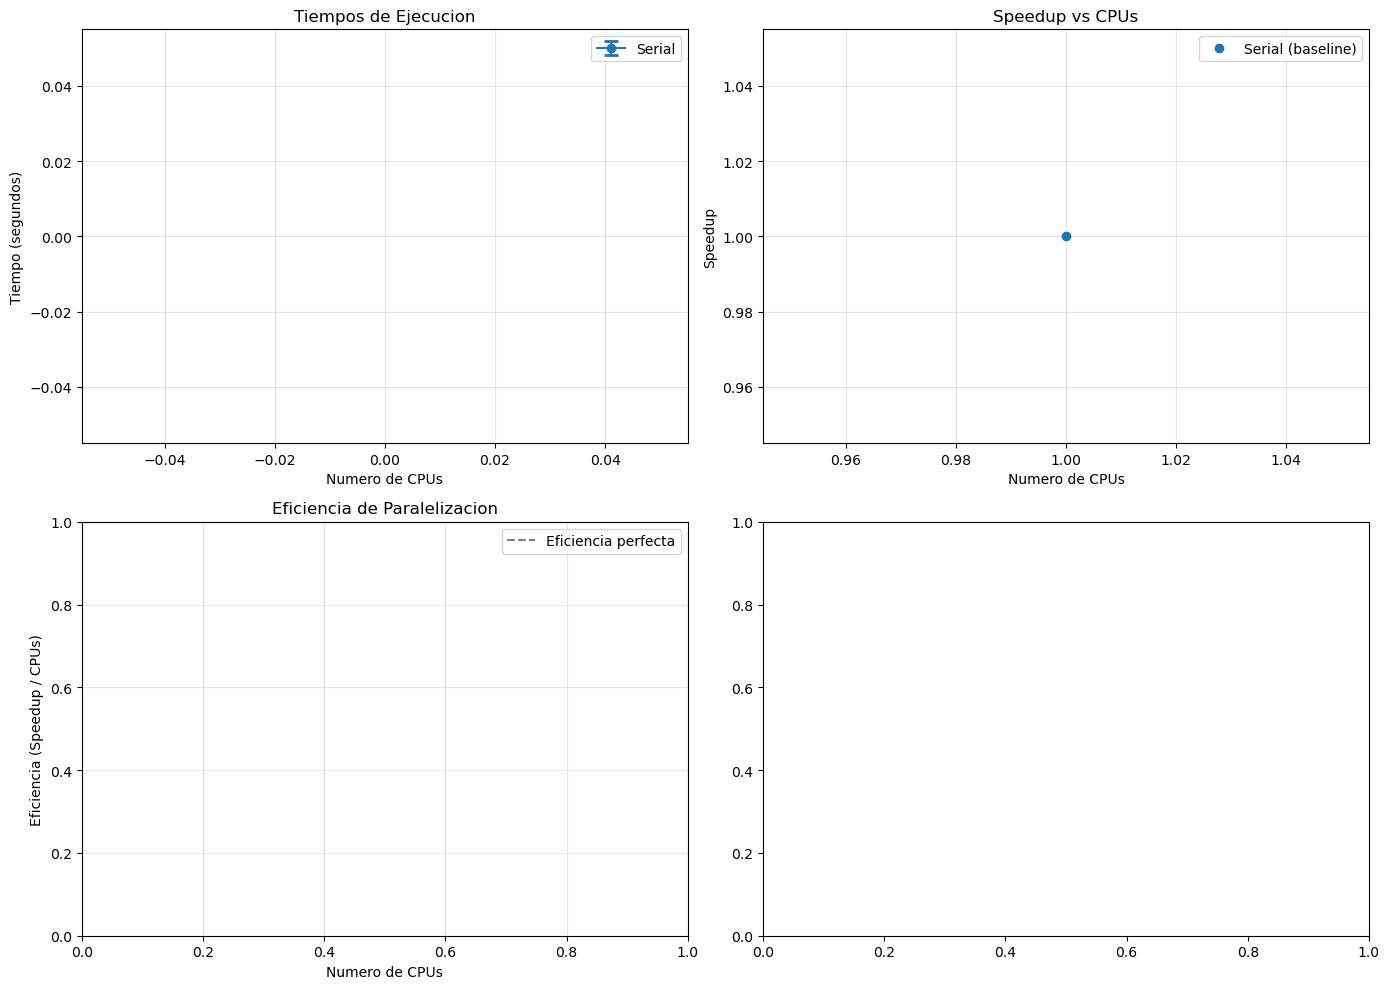


Gráficos guardados en: output\real_data_benchmark\benchmark_plots.png


In [10]:
if 'results' in locals() and results and 'analysis' in locals():
    # Directorio de salida
    output_dir = Path("output/real_data_benchmark")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Generar gráficos (save_path debe ser un archivo, no un directorio)
    try:
        plot_path = output_dir / "benchmark_plots.png"
        plot_benchmark_results(results, analysis, save_path=str(plot_path))
        print(f"\nGráficos guardados en: {plot_path}")
    except Exception as e:
        print(f"\nERROR generando gráficos: {e}")
        import traceback
        traceback.print_exc()


## Guardar Resultados

Guardemos los resultados en archivos JSON y CSV para análisis posterior.


In [11]:
if 'results' in locals() and results and 'analysis' in locals():
    # Guardar resultados (necesita config también)
    json_path, csv_path = save_results(results, analysis, config, output_dir)
    
    print(f"\nResultados guardados:")
    print(f"  JSON: {json_path}")
    print(f"  CSV: {csv_path}")


Resultados guardados en JSON: output\real_data_benchmark\benchmark_results_20251112_073734.json
Resumen guardado en CSV: output\real_data_benchmark\benchmark_summary_20251112_073734.csv

Resultados guardados:
  JSON: output\real_data_benchmark\benchmark_results_20251112_073734.json
  CSV: output\real_data_benchmark\benchmark_summary_20251112_073734.csv


## Análisis de Escalabilidad

Comparemos cómo escala multiprocessing vs loky.


In [12]:
if 'results' in locals() and results and 'analysis' in locals():
    # Análisis de escalabilidad
    analyze_scalability(results, analysis)



ANÁLISIS DE ESCALABILIDAD

Tiempo serial (baseline): nan segundos

[INFO] Multiprocessing fue saltado (notebook detectado)
       Mostrando solo resultados de Loky


Speedup por numero de CPUs:
CPUs     Loky                
------------------------------

Eficiencia (Speedup/CPUs) - Valores mas altos son mejores:
CPUs     Loky                
------------------------------

Analisis de saturacion:
